In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import spherical_jn
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

$k_\mathrm{min} = k_\mathrm{f} = 2\pi  / L_\mathrm{box}$  
$k_\mathrm{max} = k_\mathrm{Nyq} = \pi N_\mathrm{mesh} / L_\mathrm{box}$

In [4]:
Lbox, Nmesh = 3500., 1024
print ('kmin = %.4f, kmax = %.4f' % (2*np.pi / Lbox, np.pi * Nmesh / Lbox))

kmin = 0.0018, kmax = 0.9191


wide-angle expansion order:

In [5]:
nwide = 0

$Q_\ell(k) = \alpha^2 \ \langle \hat P^r_\ell(k)\rangle \ / \ N_P$, where $\hat P^r_\ell(k)$ is the **unormalized** FKP 'power spectrum' estimator of the randoms. 

Here $N_P$ is the normalization factor used in the measurements of *data* power spectrum $P_\ell(k)$. 

$P^r_\ell(k)$ is unormalized, i.e. $N^r_P \equiv 1$, as this is what nbodykit does when only one catalog is provided, see method '\_compute\_multipoles' in https://nbodykit.readthedocs.io/en/latest/_modules/nbodykit/algorithms/convpower/fkp.html#ConvolvedFFTPower

We use the FFTLog to get $Q_\ell(s)$ from $Q_\ell(k)$: 
\begin{equation}
Q_\ell(s) = i^\ell \int \frac{dk}{2\pi^2} k^2 Q_\ell(k) j_\ell(ks)
\end{equation}

See e.g. App. A of 2208.05930 for a derivation. 

norm sgc lowz: 0.922, (quad: 0.922)
norm ngc lowz: 0.925, (quad: 0.925)
norm sgc cmass: 0.929, (quad: 0.929)
norm ngc cmass: 0.929, (quad: 0.923)


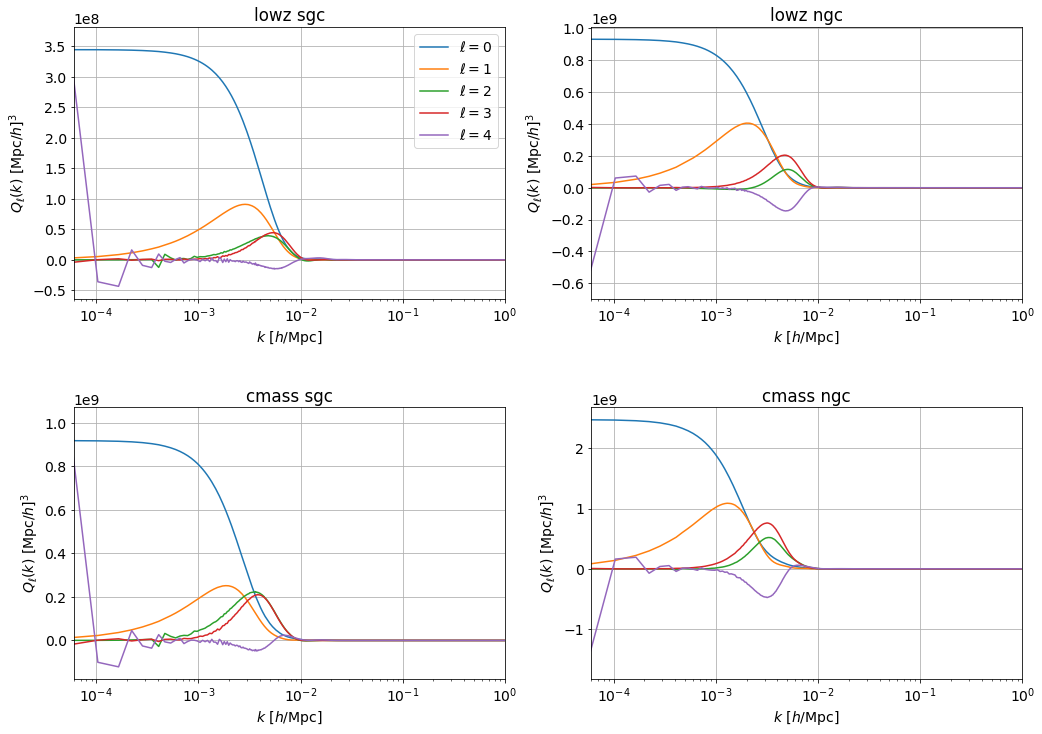

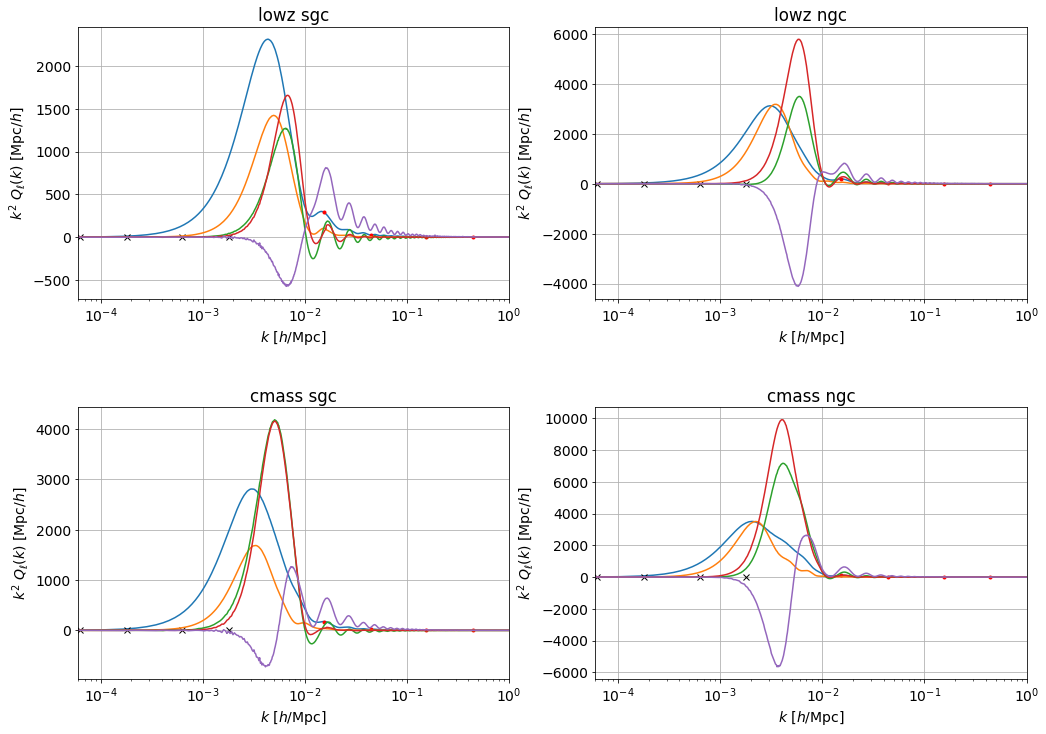

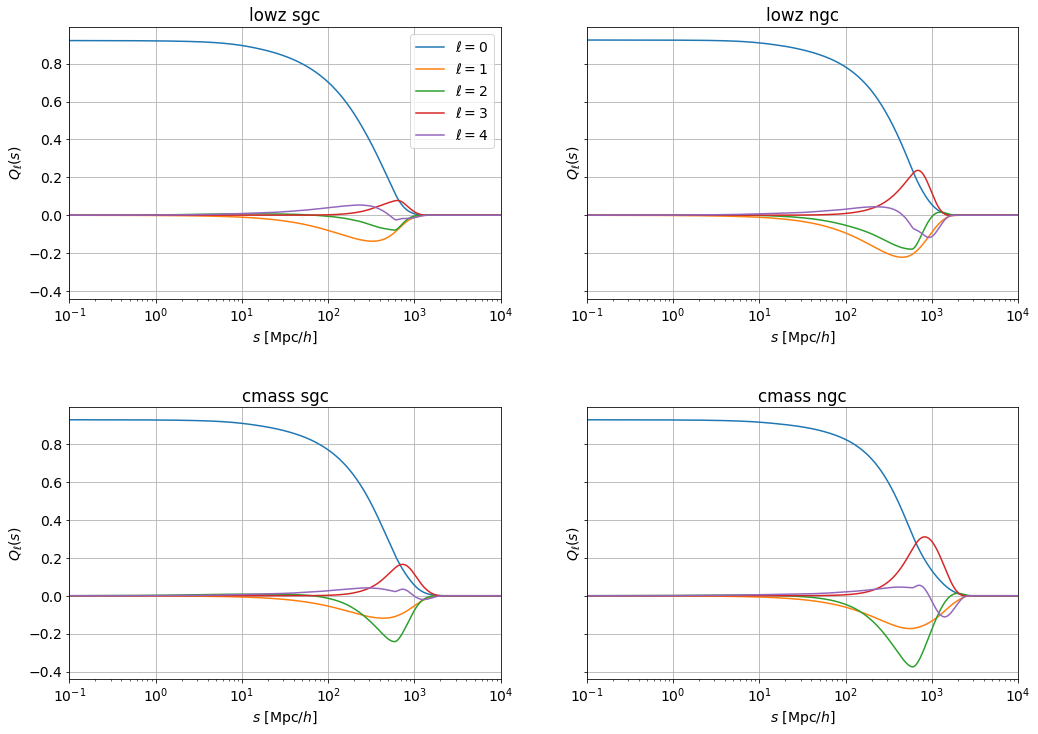

In [6]:
colors = ['C%s' % i for i in range(5)]

fig1, ax1 = plt.subplots(2,2, figsize=(17, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

fig2, ax2 = plt.subplots(2,2, figsize=(17, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

fig3, ax3 = plt.subplots(2,2, figsize=(17, 12), sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i, red in enumerate(['lowz', 'cmass']):
    for j, sky in enumerate(['sgc', 'ngc']):
        
        # normalization from nbodykit on randoms, see headers in Qk_n0_boss_red_sky.dat
        # we should always use the normalization from n = 0 to get the correct factor of 1/r1^n,
        # where r1 is the distance to the survey
        if 'lowz' in red and 'sgc' in sky: norm, alpha = 2.02006e+00, 2.11983e-02
        elif 'lowz' in red and 'ngc' in sky: norm, alpha = 5.02191e+00, 2.05963e-02 
        elif 'cmass' in red and 'sgc' in sky: norm, alpha = 4.34438e+00, 2.12161e-02
        elif 'cmass' in red and 'ngc' in sky: norm, alpha = 1.17267e+01, 2.05256e-02
        
        # Qk from concatenating boxes of various sizes for better resolution
        idx_kcut, kmins = [], []
        for n, (Lbox, sf) in enumerate(zip([100000, 35000, 10000, 3500], [2., 2., 2., 2.])):
            k_n, Q0, Q1, Q2, Q3, Q4 = np.loadtxt(
                os.path.join('Qk_', 'Qk_Lbox%s', 'Qk_n%s_boss_%s_%s.dat') % (Lbox, nwide, red, sky), unpack=True)
            Qk_n = np.array([Q0, Q1, Q2, Q3, Q4])
            if n == 0:
                kmin, kmax_0 = 2*np.pi / Lbox, np.pi * Nmesh / Lbox
                kmax_0 /= sf # security factor
                kmask = np.where((k_n < kmax_0))[0]
                k, Qk = k_n[kmask], Qk_n[:, kmask]
            else:
                kmin, kmax = 2*np.pi / Lbox, np.pi * Nmesh / Lbox
                kmax /= sf
                kmask = np.where((kmax_0 < k_n) & (k_n < kmax))[0]
                kmax_0 = kmax
                k, Qk = np.concatenate((k, k_n[kmask]), axis=-1), np.concatenate((Qk, Qk_n[:, kmask]), axis=-1)
            idx_kcut.append(len(k)-1)
            kmins.append(kmin)
        kmins = np.array(kmins)
        
        # "shot-noise" removal
        Qk[0] -= np.mean(Qk[0,-3:]) # we average the last few points to smooth over the noise
        
        # "left" extrapolation Qk ~ constant as k -> low for better normalization
        ks = np.geomspace(1e-6, k[0], 10, endpoint=False)
        Qk_extrap = []
        for l in range(Qk.shape[0]):
            Qk_extrap.append(Qk[l][0] * np.ones_like(ks))
        k = np.concatenate((ks, k))
        Qk = np.concatenate((Qk_extrap, Qk), axis=-1)
        
        # "right" extrapolation k^2 Qk ~ k^-2 as k -> high for better normalization
        id_fit = -30
        ks = np.geomspace(k[-1]+(k[-1]-k[-2]), 1e2, 100)
        Qk_extrap = []
        for l in range(Qk.shape[0]):
            a, _ = curve_fit(lambda t, a: a * t**-2, k[id_fit:], k[id_fit:]**2 * Qk[l][id_fit:])
            Qk_extrap.append(a * ks**-2 / ks**2)
        k = np.concatenate((k, ks))
        Qk = np.concatenate((Qk, Qk_extrap), axis=-1)
        
        # multiplying by two powers of alpha to go rescale the randoms power spectrum to the data one
        # and normalizing
        Qk *= alpha**2  / norm
        
        # plotting Qk
        ax1[i,j].set_title('%s %s' % (red, sky))
        for l, (qk, c) in enumerate(zip(Qk,colors)):
            ax1[i,j].plot(k, qk, '%s' % c, label=r'$\ell=%s$' % l)
        ax1[i,j].grid()
        ax1[i,j].set_xscale('log')
        ax1[i,j].set_xlabel(r'$k \ [h/{\rm Mpc}]$')
        ax1[i,j].set_ylabel(r'$Q_\ell(k) \ [{\rm Mpc}/h]^3$')
        ax1[i,j].set_xlim(6e-5, 1e0)
        if i == 0 and j == 0: ax1[i,j].legend()

        # plotting k^2 Qk
        ax2[i,j].set_title('%s %s' % (red, sky))
        for l, (qk, c) in enumerate(zip(Qk,colors)):
            if l == 0:
                ax2[i,j].plot(k, k**2 * qk, '%s' % c)
                ax2[i,j].plot(k[idx_kcut], (k**2 * qk)[idx_kcut], 'r.')
                ax2[i,j].plot(kmins, np.zeros_like(kmins), 'kx')
            else: ax2[i,j].plot(k, k**2 * qk, '%s' % c)
        ax2[i,j].grid()
        ax2[i,j].set_xscale('log')
        ax2[i,j].set_xlabel(r'$k \ [h/{\rm Mpc}]$')
        ax2[i,j].set_ylabel(r'$k^2 \ Q_\ell(k) \ [{\rm Mpc}/h]$')
        ax2[i,j].set_xlim(6e-5, 1e0)
        ### zoom on left extrapolation 
#         ax2[i,j].set_xlim(1e-6, 1e-3)
#         ax2[i,j].set_ylim(-2, 20)
        ### zoom on right extrapolation 
#         ax2[i,j].set_xlim(1e-1, 5)
#         ax2[i,j].set_ylim(-0.2, 3)
        # ax2[i,j].set_ylim(-0.1, 0.4) # monopole zoom
    
        # saving Fourier-space window Qk
        filename = 'Qk_n%s_boss_%s_%s.dat' % (nwide, red, sky)
        np.savetxt(os.path.join('Qk', filename), np.vstack([k, np.vstack([qk for qk in Qk])]).T,
                 header='k [h/Mpc], q0, q1/i, q2, q3/i, q4', fmt='%.6e')
        
        # configuration-space window Qs
        s = np.logspace(-2, 6, 2048) # keep this as the same array for fftlog in Qk_to_Wkkp.ipynb
        klog = np.geomspace(k[0], k[-1], 1024)
        kk, ss = np.meshgrid(klog, s, indexing='ij')
        Qk = np.array([Qk[0], 1j*Qk[1], Qk[2], 1j*Qk[3], Qk[4]]) # putting the odd ones back to the imaginary
        Qkk = interp1d(k, Qk, axis=-1)(kk)
        jn = np.array([1j**l * spherical_jn(l, kk*ss) for l in range(5)]) 
        Qs = np.trapz(np.real(np.einsum('ks,lks,lks->lks', kk**2, Qkk, jn)), x=klog, axis=1) / (2*np.pi**2)
        
        # plotting Qs
        ax3[i,j].set_title('%s %s' % (red, sky))
        for l, (qs, c) in enumerate(zip(Qs, colors)):
            ax3[i,j].plot(s, qs, '%s' % c, label=r'$\ell=%s$' % l)
            ax3[i,j].grid()
        ax3[i,j].set_xscale('log')
        #ax3[i,j].set_ylim(-0.5, 1)
        ax3[i,j].set_xlim(1e-1, 1e4)
        ax3[i,j].set_xlabel(r'$s \ [{\rm Mpc}/h]$')
        ax3[i,j].set_ylabel(r'$Q_\ell(s)$')
        if i == 0 and j == 0: ax3[i,j].legend()
        
        # checking normalization
        ik2Qk = interp1d(k, k**2 * np.real(Qk[0]) * spherical_jn(0, 0), kind='cubic')
        Qs0_quad = quad(ik2Qk, k[0], k[-1])[0] / (2*np.pi**2)
        print ('norm %s %s: %.3f, (quad: %.3f)' % (sky, red, Qs[0,0], Qs0_quad))
        
        # saving configuration-space window Qs !!! Here we normalize the window Qs(s->0) = 1 !!! the data has to be re-normalized accordingly !!!
        filename = 'Qs_n%s_boss_%s_%s.dat' % (nwide, red, sky)
        np.savetxt(os.path.join('Qs', filename), np.vstack([s, np.vstack([qs / Qs[0,0] for qs in Qs])]).T,
                 header='s [Mpc/h], q0, q1, q2, q3, q4', fmt='%.6e')
        
        if nwide == 0: # for old PyBird
            np.savetxt(os.path.join('Qs', 'Qs_boss_%s_%s.dat' % (red, sky)), np.vstack([s, np.vstack([qs for qs in Qs[::2]])]).T,
                 header='s [Mpc/h], q0, q2, q4', fmt='%.6e')
            np.savetxt(os.path.join('Qs', 'Qs_norm1_boss_%s_%s.dat' % (red, sky)), np.vstack([s, np.vstack([qs / Qs[0,0] for qs in Qs[::2]])]).T,
                 header='s [Mpc/h], q0, q2, q4', fmt='%.6e')
        